In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
import torch.hub

from PIL import Image
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, 
    cohen_kappa_score, mean_squared_error, mean_absolute_error,
    confusion_matrix
)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import random
import logging

import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

In [2]:
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

class RetinalDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for class_label in sorted(os.listdir(data_dir)):
            class_dir = os.path.join(data_dir, class_label)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(class_dir, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(int(class_label))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
            
        except Exception as e:
            logging.error(f"Errore nell'apertura dell'immagine: {img_path}")
            raise e

In [3]:
# **Percorsi principali**
train_data_paths = [
   "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/3_DeepDRiD",
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/6_RLDR",
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/4_Messidor2",
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/5_FGADR",
    "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/1_IDRiD"
]

test_data_path =  "/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Dataset_resize/2_APTOS"

# Dataset aggiuntivi per il test
test_additional_paths = [
    "/home/jupyter-sdm/GENITO/preprocessed_data/7_EyePACS",
    "/home/jupyter-sdm/GENITO/preprocessed_data/8_DDR"
]

EGDRBench = False

# **Mean e Std secondo DINOv2**
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

# **Trasformazioni per il dataset di addestramento**
train_transform = transforms.Compose([
    transforms.Resize((504, 504)),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomRotation(5)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# **Trasformazioni per il dataset di test**
test_transform = transforms.Compose([
    transforms.Resize((504, 504)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# **Creazione del dataset di training con più percorsi**
train_datasets = []

for train_path in train_data_paths:
    if os.path.exists(train_path):  # Controllo che il percorso esista
        train_datasets.append(RetinalDataset(train_path, transform=train_transform))
    else:
        print(f"Percorso non trovato: {train_path}")

# Unione di tutti i dataset di training
train_dataset = ConcatDataset(train_datasets)

# **Suddivisione in training e validation set**
validation_split = 0.2  # Percentuale da dedicare alla validazione
train_size = int((1 - validation_split) * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# **Creazione dei DataLoader per training e validation**
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=4, drop_last=True)

print(f"Numero di campioni nel training set: {train_size}")
print(f"Numero di campioni nel validation set: {val_size}")

# **Creazione del dataset di test con la flag**
if EGDRBench:
    test_datasets = [RetinalDataset(test_data_path, transform=test_transform)]
    for additional_path in test_additional_paths:
        if os.path.exists(additional_path):
            test_datasets.append(RetinalDataset(additional_path, transform=test_transform))
    test_dataset = ConcatDataset(test_datasets)
else:
    test_dataset = RetinalDataset(test_data_path, transform=test_transform)

# **Creazione del DataLoader per il test**
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=4)

# **Determinare il numero di classi**
num_classes = len(set([label for ds in train_datasets for label in ds.labels]))
print(f"Numero di classi: {num_classes}")


Numero di campioni nel training set: 5889
Numero di campioni nel validation set: 1473
Numero di classi: 5


Estrazione etichette in corso...
Estrazione completata.


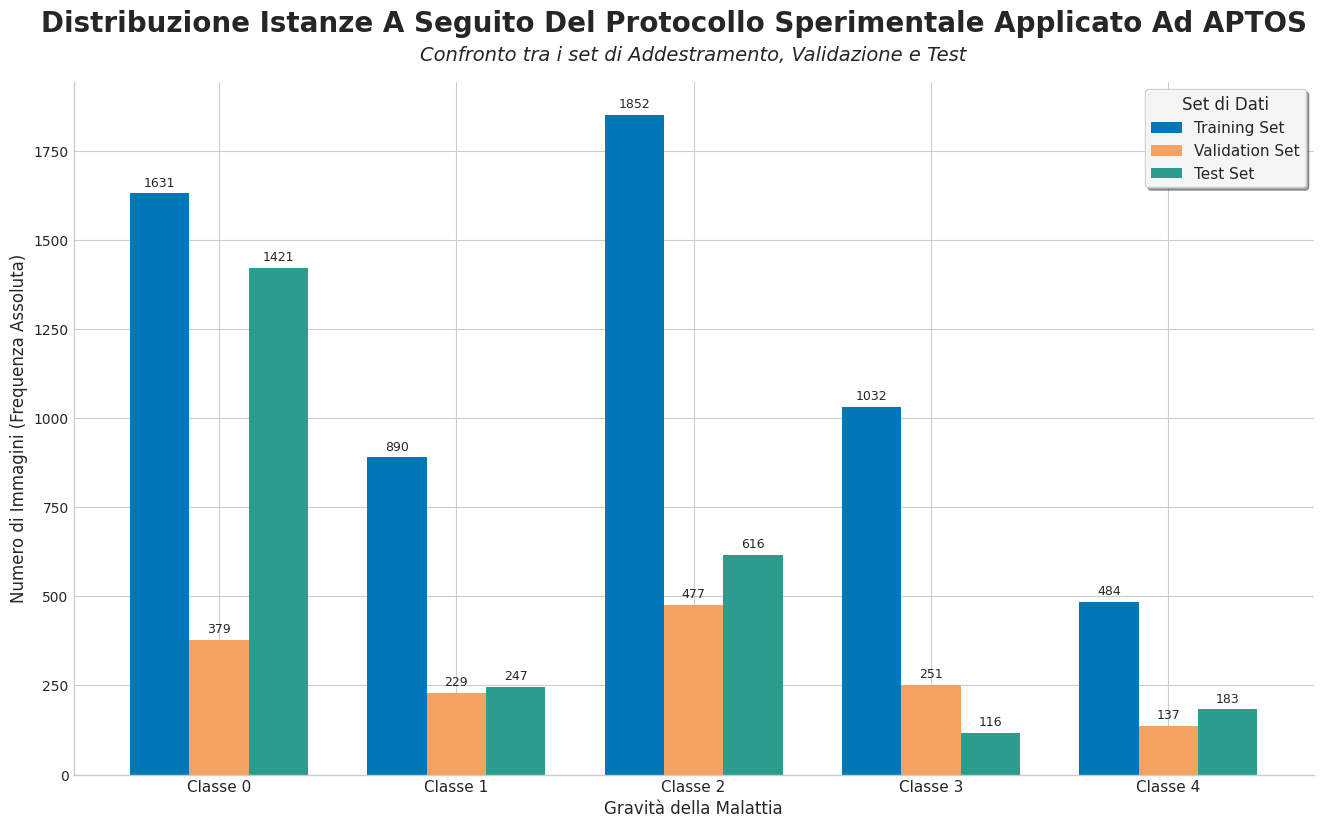

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# --- 1. Estrazione delle Etichette (invariato) ---
# Questa parte è già corretta e non necessita di modifiche.
print("Estrazione etichette in corso...")
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
test_labels = [label for _, label in test_dataset]
print("Estrazione completata.")

# --- 2. Conteggio delle Occorrenze (invariato) ---
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

num_classes = len(set(train_labels) | set(val_labels) | set(test_labels))
class_labels = [f'Classe {i}' for i in range(num_classes)]

train_values = [train_counts[i] for i in range(num_classes)]
val_values = [val_counts[i] for i in range(num_classes)]
test_values = [test_counts[i] for i in range(num_classes)]


# --- 3. Creazione del Grafico (Migliorata da Data Scientist) ---

# Applichiamo uno stile professionale per migliorare l'aspetto generale
plt.style.use('seaborn-v0_8-whitegrid')

# Creiamo la figura e l'asse con dimensioni adeguate per la leggibilità
fig, ax = plt.subplots(figsize=(16, 9))

# Definiamo una palette di colori professionale e accessibile
colors = {
    'train': '#0077b6',  # Blu aziendale
    'val': '#f4a261',    # Arancione contrastante
    'test': '#2a9d8f'    # Verde acqua complementare
}

# Definiamo posizioni e larghezza delle barre
x = np.arange(len(class_labels))
width = 0.25

# Creiamo le barre
rects1 = ax.bar(x - width, train_values, width, label='Training Set', color=colors['train'])
rects2 = ax.bar(x, val_values, width, label='Validation Set', color=colors['val'])
rects3 = ax.bar(x + width, test_values, width, label='Test Set', color=colors['test'])

# --- Personalizzazione e Pulizia Grafica ---

# Aggiungiamo un titolo e un sottotitolo per un contesto chiaro
fig.suptitle(
    'Distribuzione Istanze A Seguito Del Protocollo Sperimentale Applicato Ad APTOS',
    fontsize=20,
    fontweight='bold',
    y=0.96 # Posizionamento verticale del titolo
)
ax.set_title(
    'Confronto tra i set di Addestramento, Validazione e Test',
    fontsize=14,
    style='italic',
    pad=15 # Spaziatura dal titolo principale
)


# Etichette degli assi con font più grandi e chiari
ax.set_ylabel('Numero di Immagini (Frequenza Assoluta)', fontsize=12)
ax.set_xlabel('Gravità della Malattia', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(class_labels, fontsize=11)

# Miglioriamo la legenda
legend = ax.legend(fontsize=11, title='Set di Dati', title_fontsize=12, frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_alpha(0.9)

# Aggiungiamo etichette numeriche sopra le barre, con formattazione
ax.bar_label(rects1, padding=3, fontsize=9)
ax.bar_label(rects2, padding=3, fontsize=9)
ax.bar_label(rects3, padding=3, fontsize=9)

# Rimuoviamo le cornici (spines) destra e superiore per un look più pulito
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines

In [5]:
# Caricare il modello DINOv2 pre-addestrato 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(device)

# Congelamento di tutti i parametri del backbone
for param in backbone.parameters():
    param.requires_grad = False

for name, param in backbone.named_parameters():
    #print(name)
    if any(b in name for b in ['blocks.35.', 'blocks.36.', 'blocks.37.', 'blocks.38.', 'blocks.39.']):
        param.requires_grad = True
        

class ClassificationHead(nn.Module):
    def __init__(self, backbone, num_classes=5):
        super(ClassificationHead, self).__init__()
        self.backbone = backbone
        
        feature_dim = 1536  
        
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        
        # Gestione di tutti i possibili formati di output
        if isinstance(features, dict) and "x_norm_clstoken" in features:
            features_cls = features["x_norm_clstoken"]
        elif isinstance(features, tuple):
            features_cls = features[0]  # Assumendo che la prima entry della tupla sia il token CLS
        else:
            # Nel caso di altri formati, utilizza direttamente l'output
            # Il modello DinoV2 potrebbe restituire direttamente il tensor dei features
            features_cls = features
        
        return self.classifier(features_cls)


Using cache found in /home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main
/home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [5]:
# --------------------------------------------------------- #
#           DEFINIZIONE SEED RIPRODUCIBILITA'
# --------------------------------------------------------- #

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Configurazioni opzionali su cudnn per garantire determinismo
cudnn.deterministic = True

# --------------------------------------------------------- #
#           DEFINIZIONE FUNZIONE PRINCIPALE
# --------------------------------------------------------- #

def train_model(train_loader, val_loader, resume=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Parametri per training
    num_classes = 5
    num_epochs = 60
    patience = 5
    
    # Directory checkpoint
    checkpoint_dir = '/home/jupyter-sdm/GENITO/LAVORO_COMPLETO/Checkpoint_training/'
    os.makedirs(checkpoint_dir, exist_ok=True)

    
    # Definiamo il modello
    model = ClassificationHead(backbone, num_classes=num_classes).to(device)  
    
    # Definisco l'optimizer
    optimizer = optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': .000001},
        {'params': model.classifier.parameters(), 'lr': 0.001}])
    
    # Funzione di perdita
    criterion = nn.CrossEntropyLoss()

    # Variabili per early-stopping e metriche migliori
    best_val_loss = float('inf')
    best_accuracy = 0.0
    best_auc = 0.0
    patience_counter = 0
    
    # Struttura per salvare l'andamento delle metriche
    history = {
        'train_loss': [],
        'val_loss': [],
        'accuracy': [],
        'f1_macro': [],
        'auc': []
    }
    
    # Se voglio riprendere da checkpoint
    start_epoch = 0
    checkpoint_path = os.path.join(checkpoint_dir, 'lastest_checkpoint.pth')

    if resume:
        if os.path.exists(checkpoint_path):
            print("Caricamento checkpoint...")
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            
            # Carico i pesi nel modello
            model.load_state_dict(checkpoint['model_state_dict'])
            
            # Ricostruisco l'optimizer allo stesso modo
            optimizer = optim.AdamW([
                {'params': model.backbone.parameters(), 'lr': .000001},
                {'params': model.classifier.parameters(), 'lr': 0.001}])
            
            # Poi carico lo stato
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            # Ricarico i contatori e le metriche
            start_epoch = checkpoint['epoch'] + 1
            best_val_loss = checkpoint['best_val_loss']
            best_accuracy = checkpoint['best_accuracy']
            patience_counter = checkpoint['patience_counter']
            history = checkpoint['history']
            
            print(f"Ripreso addestramento dall'epoca {start_epoch} (best_val_loss finora: {best_val_loss:.4f})")
        else:
            print(f"Nessun checkpoint trovato in {checkpoint_path}. Avvio training da zero.")
    else:
        print("Avvio training da zero (nessun resume).")
    
    # --------------------------------------------------------- #
    #                       LOOP DI TRAINING
    # --------------------------------------------------------- #

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        history['train_loss'].append(train_loss)
        
        print(f"[Epoca {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}")
        
        # ----------------------------- #
        # VALIDAZIONE
        # ----------------------------- #
        
        model.eval()
        val_running_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(val_loss)
        
        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs)
        
        # Calcolo metriche
        accuracy_val = accuracy_score(all_labels, all_preds)
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        
        # Se devi calcolare l'AUC multi-classe
        num_classes = 5
        all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc_val = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
        
        history['accuracy'].append(accuracy_val)
        history['f1_macro'].append(f1_macro)
        history['auc'].append(auc_val)
        
        print(f"Validation Loss: {val_loss:.4f} | Accuracy: {accuracy_val:.4f} | F1 Macro: {f1_macro:.4f} | AUC: {auc_val:.4f}")
        
        # Aggiorna "best accuracy" se vuoi salvare la migliore
        if accuracy_val > best_accuracy:
            best_accuracy = accuracy_val
        
        
        # ----------------------------- #
        # EARLY STOPPING su val_loss
        # ----------------------------- #
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            # Salviamo il modello migliore (loss più bassa)
            torch.save(model.state_dict(), 'best_dinov2_model_con_preprocessing.pth')
            print(f"-> Miglior val_loss. Modello salvato ({best_val_loss:.4f}).")
        else:
            patience_counter += 1
            print(f"Pazienza: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping all'epoca {epoch+1}.")
                break
        
        # ----------------------------- #
        # SALVATAGGIO CHECKPOINT AD OGNI EPOCA
        # ----------------------------- #
        checkpoint_data = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_accuracy': best_accuracy,
            'patience_counter': patience_counter,
            'history': history
        }
        torch.save(checkpoint_data, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        # Salva come ultimo checkpoint (per riprendere in futuro)
        torch.save(checkpoint_data, checkpoint_path)
    
    # ----------------------------- #
    # PLOT DELLE METRICHE
    # ----------------------------- #
    plt.figure(figsize=(15, 10))

    # (1) Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoca')
    plt.ylabel('Loss')
    plt.title('Andamento della Loss')
    plt.legend()

    # (2) Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['accuracy'], label='Accuracy')
    plt.xlabel('Epoca')
    plt.ylabel('Accuracy')
    plt.title('Andamento dell\'Accuracy')
    plt.legend()

    # (3) F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['f1_macro'], label='F1 Macro')
    plt.xlabel('Epoca')
    plt.ylabel('F1 Score')
    plt.title('Andamento del F1 Macro')
    plt.legend()

    # (4) AUC
    plt.subplot(2, 2, 4)
    plt.plot(history['auc'], label='AUC')
    plt.xlabel('Epoca')
    plt.ylabel('AUC')
    plt.title('Andamento dell\'AUC')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    print("Addestramento completato!")
    print(f"Miglior accuracy (storica): {best_accuracy:.4f}")
    print(f"Miglior validation loss: {best_val_loss:.4f}")


# --------------------------------------------------------- #
#                    LANCIO ADDESTRAMENTO
# --------------------------------------------------------- #

flag = input("Vuoi continuare l'addestramento o ripartire? (y/Yes/yes per continuare) ")
resume_flag = (flag.lower() in ["y", "yes"])
    
# Avvio la funzione di training
train_model(train_loader, val_loader, resume=resume_flag)


Vuoi continuare l'addestramento o ripartire? (y/Yes/yes per continuare)  yes


Caricamento checkpoint...
Ripreso addestramento dall'epoca 14 (best_val_loss finora: 0.4376)


Training epoch 15/60: 100%|██████████| 1473/1473 [58:14<00:00,  2.37s/it]

[Epoca 15/60] Train Loss: 0.4167


Validation Loss: 0.4233 | Accuracy: 0.8322 | F1 Macro: 0.8294 | AUC: 0.9740
-> Miglior val_loss. Modello salvato (0.4233).


Training epoch 16/60:  17%|█▋        | 255/1473 [10:07<48:21,  2.38s/it]


KeyboardInterrupt: 

Using cache found in /home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_317431/3803465368.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mod

Risultati finali:
AUC: 0.8560 | Acc: 0.7484 | F1 Macro: 0.5221
Accuracy: 0.7484
F1 Macro: 0.5221
AUC: 0.8560
Cohen's Kappa: 0.7736


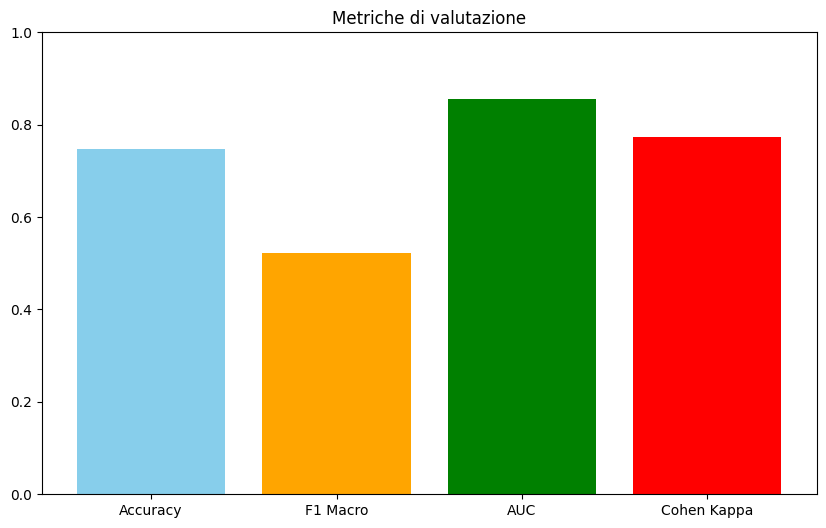

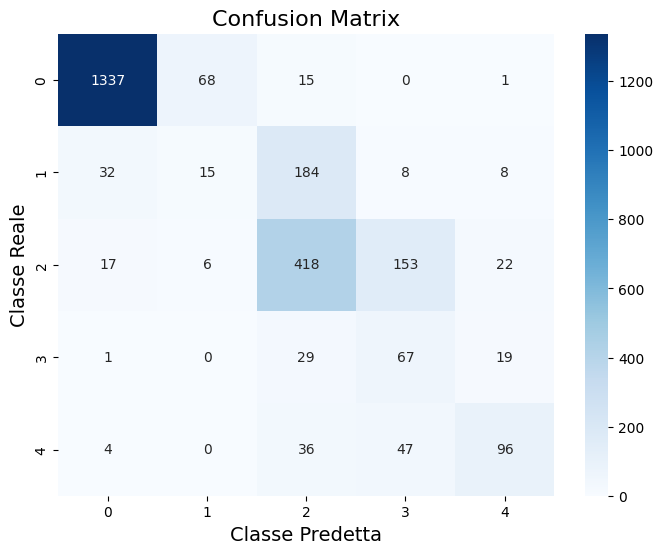

In [6]:
# Caricare il modello migliore
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(device)

model = ClassificationHead(backbone, num_classes=5).to(device)
model.load_state_dict(torch.load('best_dinov2_model_con_preprocessing.pth'))
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Calcolo delle metriche finali
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

accuracy_val = accuracy_score(all_labels, all_preds)
f1_macro = f1_score(all_labels, all_preds, average='macro')

# Assicurati di definire num_classes
num_classes = 5  
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
auc = roc_auc_score(all_labels_bin, all_probs, multi_class='ovr')
cohen_kappa = cohen_kappa_score(all_labels, all_preds, weights='linear')

print("Risultati finali:")
print(f"AUC: {auc:.4f} | Acc: {accuracy_val:.4f} | F1 Macro: {f1_macro:.4f}")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Cohen's Kappa: {cohen_kappa:.4f}")

# Visualizzazione delle metriche principali
plt.figure(figsize=(10, 6))
plt.bar(['Accuracy', 'F1 Macro', 'AUC', 'Cohen Kappa'], 
        [accuracy_val, f1_macro, auc, cohen_kappa],
        color=['skyblue', 'orange', 'green', 'red'])
plt.title('Metriche di valutazione')
plt.ylim(0, 1)
plt.show()

# Calcolo e visualizzazione della Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(num_classes)),
            yticklabels=list(range(num_classes)))
plt.xlabel('Classe Predetta', fontsize=14)
plt.ylabel('Classe Reale', fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()


In [6]:
# Caricare il modello migliore
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(device)

model = ClassificationHead(backbone, num_classes=5).to(device)
model.load_state_dict(torch.load('best_dinov2_model_APTOS.pth'))
model.eval()

from temperature_scaling import ModelWithTemperature

orig_model = model
valid_loader = val_loader

scaled_model = ModelWithTemperature(orig_model)
scaled_model.set_temperature(valid_loader)

Using cache found in /home/jupyter-sdm/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/ipykernel_568638/1585706676.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mod

Before temperature - NLL: 0.371, ECE: 0.022
Optimal temperature: 1.261
After temperature - NLL: 0.375, ECE: 0.040


ModelWithTemperature(
  (model): ClassificationHead(
    (backbone): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-39): 40 x NestedTensorBlock(
          (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1536, out_features=4608, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1536, out_features=1536, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
          (mlp): SwiGLUFFNFused(
            (w12): Linear(in_features=1536, out_features=8192, bias=True)
            (w3): Linear(in_features=4096, out_features=1536, bias=True)
  